# Read in data sets

The `INPUT_LOAD_AND_VRE_FILENAME` refers to a CSV file that contains data with the following columns:
* Timestamp (at hourly level)
* Load on the Island of Amerigo 
* Aggregated solar generation from all proposed PV sites (compiled from SAM)
* Wind generation from proposed site (compiled from SAM)

In [1]:
import os
from openpyxl import load_workbook
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math

BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('')))
DATA_DIR = os.path.join(BASE_DIR, 'amerigo_island', 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
INTERIM_DATA_DIR = os.path.join(DATA_DIR, 'interim')
FINAL_DATA_DIR = os.path.join(DATA_DIR, 'final')

INPUT_LOAD_AND_VRE_FILENAME = 'load_and_vre.csv'
FINAL_LOAD_AND_VRE_FILENAME = 'final_load_and_vre.csv' # filename of CSV after adding columns

In [2]:
# all input columns as variables for later use
date_colname = 'date'
orig_load_colname = 'load_before_transmission_mw'
solar_gen_colname = 'solar_mw'
wind_gen_colname = 'wind_mw'

load_and_vre_df = pd.read_csv(os.path.join(RAW_DATA_DIR, INPUT_LOAD_AND_VRE_FILENAME))
input_cols = [date_colname, orig_load_colname, wind_gen_colname, solar_gen_colname]
load_and_vre_df = load_and_vre_df.iloc[:, [i for i in range(len(input_cols))]]
load_and_vre_df.columns = input_cols

#### Column Names
The below lists all of the columns that we'll create from our input data set, listed as variables

In [3]:
# all derived columns as variables for later use

### COMMON - columns needed bt legacy gen, batteries, hydrogen
day_of_month_colname = 'day_of_month'
day_of_yr_colname = 'day_of_yr'
week_of_yr_colname = 'wk_of_yr'
month_colname = 'month'
year_colname = 'year'
hour_colname = 'hour'
week_colname = 'week'
load_w_transmission_loss_and_load_scale_colname = 'load_w_transmission_loss_and_load_scale'
load_vre_diff_colname = 'load_vre_diff'
total_vre_gen_colname = 'total_vre_gen_mw'
critical_load_mw_colname = 'critical_load_mw'
therm_gen_baseline_colname = 'therm_gen_baseline'
load_after_therm_gen_baseline_colname = 'load_after_therm_gen_baseline'
load_after_therm_gen_baseline_and_vre_prod_colname = 'load_after_therm_gen_baseline_and_vre_prod'
curtailment_after_therm_gen_baseline_and_vre_colname = 'curtailment_after_therm_gen_baseline_and_vre' # Post Grid Demand VRE Curtailment

### HYDROGEN
req_hydrogen_kg_colname = 'reqd_hydrogen_kg'
hydrogen_production_kg_colname = 'hydrogen_prod_kg'
hydrogen_production_m3_colname = 'hydrogen_prod_m3'
hydrogen_h2o_demand_l_colname = 'hydrogen_h2o_demand_l'
hydrogen_h2o_demand_m3_colname = 'hydrogen_h2o_demand_m3'
compression_desal_demand_mw_colname = 'compression_desal_demand_mw' 
h2_demand_comp_desal_kg_colname = 'h2_demand_comp_desal_kg'
cuml_h2_storage_kg_colname = 'cuml_h2_storage_kg'
cuml_hydrogen_demand_kg_colname = 'cuml_hydrogen_demand_kg'
cuml_h2_energy_demand_mwh_colname = 'cuml_h2_energy_demand_mwh'
h2_opex_usd_per_kg_colname = 'h2_opex_usd_per_kg'
h2_opex_electrolyzer_colname = 'h2_opex_electrolyzer'
electrolyzer_power_input_mw_colname = 'electrolyzer_power_input_mw'
fuel_cell_power_generation_mw_colname = 'fuel_cell_power_generation_mw'

### BAU - LEGACY GENERATION
thermal_gen_total_mw_colname = 'thermal_gen_total_mw'
thermal_gen_rice_mw_colname = 'thermal_gen_rice_mw'
thermal_gen_combustion_mw_colname = 'thermal_gen_combustion_mw'

#### Assumptions

Any variable in all caps represent constants that are either: 
* assumptions based on the literature
* values taken from SAM (e.g., `SOLAR_INSTALLATION_COST_MM`)
* values specified in the assignment PDF

In [4]:
# other values/assumptions needed for the analysis. 
# assumptions specific to a given technology (e.g., H2, battery) are provided in their respective section
CRITICAL_LOAD_PERC = (1/3)
SOLAR_SCALE_FACTOR = 1
WIND_SCALE_FACTOR = 1
TRANSMISSION_EFFICIENCY = 1
LOAD_SCALING_FACTOR = 1
THERMAL_BASE_GEN_MW = 35
THERMAL_MIN_GEN_MW = 0

#### Clean the input data set
The input data set might have `null` values, and we want to make sure the date column is formatted in the way we expect downstream

In [5]:
def clean_input_columns(df):

    cleaned_df = df.copy()
    cleaned_df = cleaned_df.dropna(how='all')

    cleaned_df[date_colname] = pd.to_datetime(cleaned_df[date_colname])
    
    # all solar vals need to be > 0
    cleaned_df[solar_gen_colname] = cleaned_df[solar_gen_colname]\
        .apply(lambda x: x if x > 0 else 0)
    
    cleaned_df[month_colname] = cleaned_df[date_colname].map(lambda x: x.month)
    cleaned_df[day_of_month_colname] = cleaned_df[date_colname].map(lambda x: x.day)
    cleaned_df[day_of_yr_colname] = cleaned_df[date_colname].map(lambda x: x.timetuple().tm_yday)
    cleaned_df[hour_colname] = cleaned_df[date_colname].map(lambda x: x.hour)
    cleaned_df[week_colname] = cleaned_df[date_colname].map(lambda x: x.week)
    
    return cleaned_df

In [6]:
cleaned_load_and_vre_df = clean_input_columns(load_and_vre_df)

In [7]:
cleaned_load_and_vre_df

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,hour,week
0,2017-01-01 00:00:00,35.1,1.67966,0.0,1,1,1,0,52
1,2017-01-01 01:00:00,35.1,1.23327,0.0,1,1,1,1,52
2,2017-01-01 02:00:00,34.6,1.09193,0.0,1,1,1,2,52
3,2017-01-01 03:00:00,34.2,1.46510,0.0,1,1,1,3,52
4,2017-01-01 04:00:00,33.8,1.12029,0.0,1,1,1,4,52
...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 19:00:00,45.5,6.76534,0.0,12,31,365,19,52
8756,2017-12-31 20:00:00,46.5,6.20556,0.0,12,31,365,20,52
8757,2017-12-31 21:00:00,45.0,8.72619,0.0,12,31,365,21,52
8758,2017-12-31 22:00:00,41.7,7.23441,0.0,12,31,365,22,52


#### Assertions
Since the rows of the input data set are expected to represent hours over one year, we'd expect there to be 8760 rows.

Also check that each day only has 24 rows

In [8]:
assert len(cleaned_load_and_vre_df) == 8760, "Expected one row per hour in year (8760), got {} rows".format(len(load_and_gen_df))

for day_of_yr in cleaned_load_and_vre_df[day_of_yr_colname].unique():
    if len(cleaned_load_and_vre_df[cleaned_load_and_vre_df[day_of_yr_colname] == day_of_yr]) != 24:
        assert ValueError("Day {} has {} values".format(day_of_yr, len(cleaned_load_and_vre_df[cleaned_load_and_vre_df[day_of_yr_colname] == day_of_yr])))
        

Each of the technologies considered for resilience have some columns in common. This function creates these columns for use in the battery case, business-as-usual case, and hydrogen case

In [9]:
def add_common_derived_columns(df):
    
    decorated_df = df.copy()
    
    decorated_df[solar_gen_colname] = \
        decorated_df[solar_gen_colname] \
        * SOLAR_SCALE_FACTOR
    
    decorated_df[wind_gen_colname] = \
        decorated_df[wind_gen_colname] \
        * WIND_SCALE_FACTOR
        
    decorated_df[load_w_transmission_loss_and_load_scale_colname] = \
        decorated_df[orig_load_colname] / \
        (TRANSMISSION_EFFICIENCY * LOAD_SCALING_FACTOR)    
    
    decorated_df[critical_load_mw_colname] = decorated_df[load_w_transmission_loss_and_load_scale_colname] * CRITICAL_LOAD_PERC
    
    decorated_df[therm_gen_baseline_colname] = THERMAL_BASE_GEN_MW
    
    decorated_df[load_after_therm_gen_baseline_colname] = \
        decorated_df[load_w_transmission_loss_and_load_scale_colname] \
        - decorated_df[therm_gen_baseline_colname]
    
    decorated_df[total_vre_gen_colname] = \
        decorated_df[wind_gen_colname] + decorated_df[solar_gen_colname]
    
    decorated_df[load_vre_diff_colname] = \
        decorated_df[load_w_transmission_loss_and_load_scale_colname] \
        - decorated_df[total_vre_gen_colname]
        
    decorated_df[load_after_therm_gen_baseline_and_vre_prod_colname] = \
        (decorated_df[load_after_therm_gen_baseline_colname] \
        - decorated_df[total_vre_gen_colname]).map(lambda x: x if x > 0 else 0)
    
    decorated_df[curtailment_after_therm_gen_baseline_and_vre_colname] = \
        (decorated_df[total_vre_gen_colname] \
        - decorated_df[load_after_therm_gen_baseline_colname]).map(lambda x: x if x > 0 else 0)

    return decorated_df

In [10]:
final_load_and_vre_df = add_common_derived_columns(cleaned_load_and_vre_df)

# drop the CSV within the project, mostly as convenience. Don't want to 
final_load_and_vre_df.to_csv(os.path.join(INTERIM_DATA_DIR, FINAL_LOAD_AND_VRE_FILENAME), index=False)

In [11]:
final_load_and_vre_df.head(24)

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,hour,week,load_w_transmission_loss_and_load_scale,critical_load_mw,therm_gen_baseline,load_after_therm_gen_baseline,total_vre_gen_mw,load_vre_diff,load_after_therm_gen_baseline_and_vre_prod,curtailment_after_therm_gen_baseline_and_vre
0,2017-01-01 00:00:00,35.1,1.679660,0.000000,1,1,1,0,52,35.1,11.700000,35,0.1,1.679660,33.420340,0.000000,1.579660
1,2017-01-01 01:00:00,35.1,1.233270,0.000000,1,1,1,1,52,35.1,11.700000,35,0.1,1.233270,33.866730,0.000000,1.133270
2,2017-01-01 02:00:00,34.6,1.091930,0.000000,1,1,1,2,52,34.6,11.533333,35,-0.4,1.091930,33.508070,0.000000,1.491930
3,2017-01-01 03:00:00,34.2,1.465100,0.000000,1,1,1,3,52,34.2,11.400000,35,-0.8,1.465100,32.734900,0.000000,2.265100
4,2017-01-01 04:00:00,33.8,1.120290,0.000000,1,1,1,4,52,33.8,11.266667,35,-1.2,1.120290,32.679710,0.000000,2.320290
5,2017-01-01 05:00:00,33.4,0.913553,0.000000,1,1,1,5,52,33.4,11.133333,35,-1.6,0.913553,32.486447,0.000000,2.513553
6,2017-01-01 06:00:00,33.3,1.841290,0.000000,1,1,1,6,52,33.3,11.100000,35,-1.7,1.841290,31.458710,0.000000,3.541290
7,2017-01-01 07:00:00,33.8,1.593750,6.897810,1,1,1,7,52,33.8,11.266667,35,-1.2,8.491560,25.308440,0.000000,9.691560
8,2017-01-01 08:00:00,34.7,1.177780,21.358540,1,1,1,8,52,34.7,11.566667,35,-0.3,22.536320,12.163680,0.000000,22.836320
9,2017-01-01 09:00:00,34.7,0.782468,27.960274,1,1,1,9,52,34.7,11.566667,35,-0.3,28.742742,5.957258,0.000000,29.042742


# Battery Analysis

Using the data set above, we can create a battery-specific analysis from the observed data.

This function takes in the hourly data and a config that contains properties of a battery. 

In [12]:
### BATTERIES ################################################################
# intermediate calc columns
battery_soc_colname = 'battery_soc_mwh'
battery_discharge_mw_colname = 'battery_discharge_mw' # Battery Production, MW 
battery_curtailment_after_charge_mw_colname = 'battery_curtailment_after_charge_mw'
thermal_gen_delta_from_baseline_colname = 'thermal_gen_delta_from_baseline'
# optimized case columns

# battery properties that calcs depend on
battery_capacity_mwh_config_prop = "battery_capacity_mwh"
battery_power_mw_config_prop = "battery_power_mw"
battery_efficiency_config_prop = "battery_efficiency"

# final battery col names
battery_final_thermal_prod_mw_colname = 'battery_final_thermal_prod_mw'
battery_final_remaining_load_mw_colname = 'battery_final_remaining_load_mw' 
battery_vre_to_grid_colname = 'battery_vre_to_grid'
battery_to_load_mw_colname = 'battery_to_load_mw'
battery_final_vre_to_battery_colname = 'battery_vre_to_battery'
battery_final_curtailed_vre_mw = 'battery_curtailed_vre_mw'
cruise_ships_boolean_colname = 'cruise_ships_boolean'
battery_curtail_available_for_cruise_colname = 'battery_curtail_available_for_cruise'
##############################################################################

# Battery storage ##################################
BATTERY_CAPACITY_MWH = 220
BATTERY_POWER_MW = 40
BATTERY_EFFICIENCY = 0.875
BATTERY_DEPTH_OF_DISCHARGE = 0.5
BATTERY_MIN_SOC_MWH = (1 - BATTERY_DEPTH_OF_DISCHARGE) * BATTERY_CAPACITY_MWH
BATTERY_POWER_KW = BATTERY_POWER_MW * 1000
BATTERY_CAPEX = ((BATTERY_CAPACITY_MWH * 1000 * 260) + (BATTERY_POWER_MW * 1000 * 530))
BATT_O_AND_M_COST_PER_KW_YR = .025 * (BATTERY_CAPEX / BATTERY_POWER_KW) #(https://www.nrel.gov/docs/fy19osti/73222.pdf)
BATTERY_SOC_BEGINNING_OF_YR = 179.91
#####################################################

In [13]:
def add_intermediate_battery_cols(hourly_df, battery_config):
    
    decorated_df = hourly_df.copy()
    
    battery_capacity = battery_config[battery_capacity_mwh_config_prop]
    battery_efficiency = battery_config[battery_efficiency_config_prop]
    
    decorated_df[battery_soc_colname] = None
    decorated_df[battery_curtailment_after_charge_mw_colname] = None
    decorated_df[battery_discharge_mw_colname] = None

    decorated_df.reset_index()
    for idx, row in decorated_df.iterrows():

        if idx == 0: # First row of data set, so can't take previous hour's values
            
            soc_val = \
                BATTERY_SOC_BEGINNING_OF_YR \
                - (row[load_after_therm_gen_baseline_and_vre_prod_colname] \
                / battery_efficiency) \
                + row[curtailment_after_therm_gen_baseline_and_vre_colname]
            
            batt_curtailment_val = BATTERY_SOC_BEGINNING_OF_YR \
                - row[load_after_therm_gen_baseline_and_vre_prod_colname] \
                + row[curtailment_after_therm_gen_baseline_and_vre_colname] \
                - soc_val
            
            discharge_val = BATTERY_SOC_BEGINNING_OF_YR \
                - row[load_after_therm_gen_baseline_and_vre_prod_colname] \
                + row[curtailment_after_therm_gen_baseline_and_vre_colname] \
                - soc_val \
                - batt_curtailment_val
                
        else: # Subsequent rows. Has values for previous hour
            
            prev_soc = decorated_df.loc[idx - 1, battery_soc_colname]
            load_after_therm_gen_baseline_and_vre_prod = row[load_after_therm_gen_baseline_and_vre_prod_colname]
            curtailment_after_therm_gen_baseline_and_vre = row[curtailment_after_therm_gen_baseline_and_vre_colname]
            
            soc_val = prev_soc \
                - (load_after_therm_gen_baseline_and_vre_prod / battery_efficiency)\
                + curtailment_after_therm_gen_baseline_and_vre
            
            soc_val = soc_val if soc_val > BATTERY_MIN_SOC_MWH else BATTERY_MIN_SOC_MWH
            soc_val = soc_val if soc_val < BATTERY_CAPACITY_MWH else BATTERY_CAPACITY_MWH
            
            batt_curtailment_val = prev_soc \
                - load_after_therm_gen_baseline_and_vre_prod \
                + curtailment_after_therm_gen_baseline_and_vre \
                - soc_val
            
            batt_curtailment_val = batt_curtailment_val if batt_curtailment_val > 0 else 0
            
            discharge_val = (prev_soc - soc_val) if (prev_soc - soc_val) > 0 else 0
        
        decorated_df.at[idx, battery_soc_colname] = soc_val
        decorated_df.at[idx, battery_curtailment_after_charge_mw_colname] = batt_curtailment_val
        decorated_df.at[idx, battery_discharge_mw_colname] = discharge_val

    decorated_df[battery_soc_colname] = decorated_df[battery_soc_colname].astype(float)
    decorated_df[battery_curtailment_after_charge_mw_colname] = decorated_df[battery_curtailment_after_charge_mw_colname].astype(float)
    decorated_df[battery_discharge_mw_colname] = decorated_df[battery_discharge_mw_colname].astype(float)

    decorated_df[thermal_gen_delta_from_baseline_colname] = decorated_df.apply(
        lambda x: -x[battery_curtailment_after_charge_mw_colname] \
            if x[battery_curtailment_after_charge_mw_colname] < x[therm_gen_baseline_colname] - THERMAL_MIN_GEN_MW  \
            else THERMAL_MIN_GEN_MW - x[therm_gen_baseline_colname], axis=1
    )
    
    return decorated_df

In [14]:
battery_config = {
    battery_capacity_mwh_config_prop : BATTERY_CAPACITY_MWH,
    battery_power_mw_config_prop : BATTERY_POWER_MW,
    battery_efficiency_config_prop : BATTERY_EFFICIENCY
}

In [15]:
battery_hourly_df = add_intermediate_battery_cols(final_load_and_vre_df, battery_config)

In [16]:
battery_hourly_df.head(24)

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,hour,week,load_w_transmission_loss_and_load_scale,...,therm_gen_baseline,load_after_therm_gen_baseline,total_vre_gen_mw,load_vre_diff,load_after_therm_gen_baseline_and_vre_prod,curtailment_after_therm_gen_baseline_and_vre,battery_soc_mwh,battery_curtailment_after_charge_mw,battery_discharge_mw,thermal_gen_delta_from_baseline
0,2017-01-01 00:00:00,35.1,1.679660,0.000000,1,1,1,0,52,35.1,...,35,0.1,1.679660,33.420340,0.000000,1.579660,181.489660,0.000000,0.000000,-0.000000
1,2017-01-01 01:00:00,35.1,1.233270,0.000000,1,1,1,1,52,35.1,...,35,0.1,1.233270,33.866730,0.000000,1.133270,182.622930,0.000000,0.000000,-0.000000
2,2017-01-01 02:00:00,34.6,1.091930,0.000000,1,1,1,2,52,34.6,...,35,-0.4,1.091930,33.508070,0.000000,1.491930,184.114860,0.000000,0.000000,-0.000000
3,2017-01-01 03:00:00,34.2,1.465100,0.000000,1,1,1,3,52,34.2,...,35,-0.8,1.465100,32.734900,0.000000,2.265100,186.379960,0.000000,0.000000,-0.000000
4,2017-01-01 04:00:00,33.8,1.120290,0.000000,1,1,1,4,52,33.8,...,35,-1.2,1.120290,32.679710,0.000000,2.320290,188.700250,0.000000,0.000000,-0.000000
5,2017-01-01 05:00:00,33.4,0.913553,0.000000,1,1,1,5,52,33.4,...,35,-1.6,0.913553,32.486447,0.000000,2.513553,191.213803,0.000000,0.000000,-0.000000
6,2017-01-01 06:00:00,33.3,1.841290,0.000000,1,1,1,6,52,33.3,...,35,-1.7,1.841290,31.458710,0.000000,3.541290,194.755093,0.000000,0.000000,-0.000000
7,2017-01-01 07:00:00,33.8,1.593750,6.897810,1,1,1,7,52,33.8,...,35,-1.2,8.491560,25.308440,0.000000,9.691560,204.446653,0.000000,0.000000,-0.000000
8,2017-01-01 08:00:00,34.7,1.177780,21.358540,1,1,1,8,52,34.7,...,35,-0.3,22.536320,12.163680,0.000000,22.836320,220.000000,7.282973,0.000000,-7.282973
9,2017-01-01 09:00:00,34.7,0.782468,27.960274,1,1,1,9,52,34.7,...,35,-0.3,28.742742,5.957258,0.000000,29.042742,220.000000,29.042742,0.000000,-29.042742


In [17]:
def add_optimized_battery_columns(df, config):
    
    decorated_df = df.copy()
    
    decorated_df[battery_final_thermal_prod_mw_colname] = \
        decorated_df[therm_gen_baseline_colname] + decorated_df[thermal_gen_delta_from_baseline_colname]
    
    decorated_df[battery_final_remaining_load_mw_colname] = \
        decorated_df[load_w_transmission_loss_and_load_scale_colname] - decorated_df[battery_final_thermal_prod_mw_colname]
    
    decorated_df[battery_vre_to_grid_colname] = decorated_df.apply(
        lambda x: x[battery_final_remaining_load_mw_colname] \
            if x[battery_final_remaining_load_mw_colname] < x[total_vre_gen_colname] \
            else x[total_vre_gen_colname]
        , axis=1
    )

    decorated_df[battery_to_load_mw_colname] = decorated_df.apply(
        lambda x: x[battery_final_remaining_load_mw_colname] - x[battery_vre_to_grid_colname] 
            if x[battery_final_remaining_load_mw_colname] - x[battery_vre_to_grid_colname] > 0 \
            else 0
        ,axis=1
    )
    decorated_df[battery_to_load_mw_colname] = decorated_df[battery_to_load_mw_colname].astype(float)
    
    decorated_df[battery_final_curtailed_vre_mw] = \
        decorated_df[battery_curtailment_after_charge_mw_colname] + decorated_df[thermal_gen_delta_from_baseline_colname]
    
    decorated_df[battery_final_vre_to_battery_colname] = None
    decorated_df.reset_index()
    for idx, row in decorated_df.iterrows():
        
        if idx == 0:
            vre_to_battery_val = 0 if row[battery_final_remaining_load_mw_colname] - row[battery_vre_to_grid_colname] > 0\
                else BATTERY_CAPACITY_MWH - row[battery_soc_colname]
            
        else:
            vre_to_battery_val = row[battery_discharge_mw_colname] \
                if row[battery_final_remaining_load_mw_colname] - row[battery_vre_to_grid_colname] <= 0 \
                else 0 
        
        decorated_df.at[idx, battery_final_vre_to_battery_colname] = vre_to_battery_val
    
    decorated_df[cruise_ships_boolean_colname] = decorated_df.apply( 
        lambda x: True if 8 <= int(x[hour_colname]) <= 16 else False
        , axis=1)
    
    decorated_df[battery_curtail_available_for_cruise_colname] = decorated_df.apply( 
        lambda x: x[battery_final_curtailed_vre_mw] if x[cruise_ships_boolean_colname] == True else 0
        , axis=1)
    
    return decorated_df

In [18]:
battery_hourly_df = add_optimized_battery_columns(battery_hourly_df, battery_config)

In [19]:
battery_hourly_df.head(24)

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,hour,week,load_w_transmission_loss_and_load_scale,...,battery_discharge_mw,thermal_gen_delta_from_baseline,battery_final_thermal_prod_mw,battery_final_remaining_load_mw,battery_vre_to_grid,battery_to_load_mw,battery_curtailed_vre_mw,battery_vre_to_battery,cruise_ships_boolean,battery_curtail_available_for_cruise
0,2017-01-01 00:00:00,35.1,1.679660,0.000000,1,1,1,0,52,35.1,...,0.000000,-0.000000,35.000000,0.100000,0.100000,0.000000e+00,0.000000,38.5103,False,0.000000
1,2017-01-01 01:00:00,35.1,1.233270,0.000000,1,1,1,1,52,35.1,...,0.000000,-0.000000,35.000000,0.100000,0.100000,0.000000e+00,0.000000,0,False,0.000000
2,2017-01-01 02:00:00,34.6,1.091930,0.000000,1,1,1,2,52,34.6,...,0.000000,-0.000000,35.000000,-0.400000,-0.400000,0.000000e+00,0.000000,0,False,0.000000
3,2017-01-01 03:00:00,34.2,1.465100,0.000000,1,1,1,3,52,34.2,...,0.000000,-0.000000,35.000000,-0.800000,-0.800000,0.000000e+00,0.000000,0,False,0.000000
4,2017-01-01 04:00:00,33.8,1.120290,0.000000,1,1,1,4,52,33.8,...,0.000000,-0.000000,35.000000,-1.200000,-1.200000,0.000000e+00,0.000000,0,False,0.000000
5,2017-01-01 05:00:00,33.4,0.913553,0.000000,1,1,1,5,52,33.4,...,0.000000,-0.000000,35.000000,-1.600000,-1.600000,0.000000e+00,0.000000,0,False,0.000000
6,2017-01-01 06:00:00,33.3,1.841290,0.000000,1,1,1,6,52,33.3,...,0.000000,-0.000000,35.000000,-1.700000,-1.700000,0.000000e+00,0.000000,0,False,0.000000
7,2017-01-01 07:00:00,33.8,1.593750,6.897810,1,1,1,7,52,33.8,...,0.000000,-0.000000,35.000000,-1.200000,-1.200000,0.000000e+00,0.000000,0,False,0.000000
8,2017-01-01 08:00:00,34.7,1.177780,21.358540,1,1,1,8,52,34.7,...,0.000000,-7.282973,27.717027,6.982973,6.982973,0.000000e+00,0.000000,0,True,0.000000
9,2017-01-01 09:00:00,34.7,0.782468,27.960274,1,1,1,9,52,34.7,...,0.000000,-29.042742,5.957258,28.742742,28.742742,7.105427e-15,0.000000,0,True,0.000000


# Legacy Generation

In [20]:
### LEGACY GENERATION ################################################################
# column names
thermal_gen_total_mw_colname = 'gen_thermal_total_mw'
thermal_gen_total_kwh_colname = 'thermal_gen_total_kwh'

# assumptions
NOMINAL_HEAT_RATE_BTU_COMBUSTION = 17680
NOMINAL_HEAT_RATE_BTU_RICE = 9827
######################################################################################

In [21]:
bau_and_battery_df = battery_hourly_df.copy()
bau_and_battery_df[thermal_gen_total_mw_colname] = bau_and_battery_df[load_w_transmission_loss_and_load_scale_colname] - bau_and_battery_df[total_vre_gen_colname]
bau_and_battery_df[thermal_gen_total_mw_colname] = bau_and_battery_df[thermal_gen_total_mw_colname].map(lambda x: x if x > 0 else 0)
bau_and_battery_df[thermal_gen_total_kwh_colname] = bau_and_battery_df[thermal_gen_total_mw_colname] * 1000

In [22]:
therm_rice_config = {
    "o_and_m" : .0105, # in cents / kwh
    "nominal_heat_rate_btu" : NOMINAL_HEAT_RATE_BTU_RICE, # in BTU / kWh
    "fuel_cost" : 2.50, # in $ / gallon
    "nominal_heat_rate_gal" : NOMINAL_HEAT_RATE_BTU_RICE / 139_000,
    "column_prepend" : "rice"
}

therm_combustion_config = {
    "o_and_m" : .0046, # in $ / kWh
    "nominal_heat_rate_btu" : NOMINAL_HEAT_RATE_BTU_COMBUSTION, # in BTU / kWh 
    "fuel_cost" : 2.50, # in $ / gallon
    "nominal_heat_rate_gal" : NOMINAL_HEAT_RATE_BTU_COMBUSTION / 139_000,
    "column_prepend" : "combustion"
}


In [23]:
def calc_bau_cols(df, config):
    
    decorated_df = df.copy()

    col_prepend = config['column_prepend']
    o_and_m = config['o_and_m']
    nominal_heat_rate_gal = config['nominal_heat_rate_gal']
    fuel_cost = config['fuel_cost']
    
    decorated_df['{}_fuel_cost'.format(col_prepend)] = decorated_df[thermal_gen_total_kwh_colname] * nominal_heat_rate_gal * fuel_cost
    decorated_df['{}_o_and_m_cost'.format(col_prepend)] = decorated_df[thermal_gen_total_kwh_colname] * o_and_m
    decorated_df['{}_total_cost'.format(col_prepend)] = decorated_df['{}_o_and_m_cost'.format(col_prepend)] + decorated_df['{}_fuel_cost'.format(col_prepend)]
    
    return decorated_df

In [24]:
bau_and_battery_df = calc_bau_cols(bau_and_battery_df, therm_rice_config)
bau_and_battery_df = calc_bau_cols(bau_and_battery_df, therm_combustion_config)

bau_and_battery_df.head(24)

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,hour,week,load_w_transmission_loss_and_load_scale,...,cruise_ships_boolean,battery_curtail_available_for_cruise,gen_thermal_total_mw,thermal_gen_total_kwh,rice_fuel_cost,rice_o_and_m_cost,rice_total_cost,combustion_fuel_cost,combustion_o_and_m_cost,combustion_total_cost
0,2017-01-01 00:00:00,35.1,1.679660,0.000000,1,1,1,0,52,35.1,...,False,0.000000,33.420340,33420.3400,5906.864769,350.913570,6257.778339,10627.187252,153.733564,10780.920816
1,2017-01-01 01:00:00,35.1,1.233270,0.000000,1,1,1,1,52,35.1,...,False,0.000000,33.866730,33866.7300,5985.761793,355.600665,6341.362458,10769.132849,155.786958,10924.919807
2,2017-01-01 02:00:00,34.6,1.091930,0.000000,1,1,1,2,52,34.6,...,False,0.000000,33.508070,33508.0700,5922.370574,351.834735,6274.205309,10655.084129,154.137122,10809.221251
3,2017-01-01 03:00:00,34.2,1.465100,0.000000,1,1,1,3,52,34.2,...,False,0.000000,32.734900,32734.9000,5785.716948,343.716450,6129.433398,10409.227194,150.580540,10559.807734
4,2017-01-01 04:00:00,33.8,1.120290,0.000000,1,1,1,4,52,33.8,...,False,0.000000,32.679710,32679.7100,5775.962413,343.136955,6119.099368,10391.677568,150.326666,10542.004234
5,2017-01-01 05:00:00,33.4,0.913553,0.000000,1,1,1,5,52,33.4,...,False,0.000000,32.486447,32486.4470,5741.804221,341.107694,6082.911914,10330.222715,149.437656,10479.660371
6,2017-01-01 06:00:00,33.3,1.841290,0.000000,1,1,1,6,52,33.3,...,False,0.000000,31.458710,31458.7100,5560.157251,330.316455,5890.473706,10003.417137,144.710066,10148.127203
7,2017-01-01 07:00:00,33.8,1.593750,6.897810,1,1,1,7,52,33.8,...,False,0.000000,25.308440,25308.4400,4473.130214,265.738620,4738.868834,8047.719770,116.418824,8164.138594
8,2017-01-01 08:00:00,34.7,1.177780,21.358540,1,1,1,8,52,34.7,...,True,0.000000,12.163680,12163.6800,2149.864809,127.718640,2277.583449,3867.875223,55.952928,3923.828151
9,2017-01-01 09:00:00,34.7,0.782468,27.960274,1,1,1,9,52,34.7,...,True,0.000000,5.957258,5957.2580,1052.913208,62.551209,1115.464417,1894.322328,27.403387,1921.725715


In [25]:
bau_and_battery_df[[
    "rice_fuel_cost",
    "rice_o_and_m_cost",
    "combustion_fuel_cost",
    "combustion_o_and_m_cost"
]].astype(float).sum()

rice_fuel_cost             3.859606e+07
rice_o_and_m_cost          2.292905e+06
combustion_fuel_cost       6.943914e+07
combustion_o_and_m_cost    1.004511e+06
dtype: float64

# Hydrogen-specific analysis

In [26]:
h2_df = bau_and_battery_df.copy()

In [27]:
### HYDROGEN STORAGE ################################################################
# physical constants
H2_DENSITY_STP_KG_PER_M3 = 0.0813                # Hydrogen Tools. (2020). Hydrogen Density at different temperatures and pressures. Retrieved from https://h2tools.org/hyarc/hydrogen-data/hydrogen-density-different-temperatures-and-pressures
H2_LHV_MJ_PER_KG = 119.93                        # Hydrogen Fuel Cell Engines and Related Technologies. (2001). Module 1: Hydrogen Properties. Hydrogen Fuel Cell Engines, 41. 
H2_ENERGY_CONSUMPTION_H2O_DESAL_KWH_PER_M3 = 1.8 # Elimelech, M., & Phillip, W. A. (2011). The future of seawater desalination: Energy, technology, and the environment. Science, 333(6043), 712–717. https://doi.org/10.1126/science.1200488
# electrolyzer
H2_ELEC_EFF_ELECTROLYZER_WRT_LHV_OF_H2 = .601    # Peterson, D., Vickers, J., & DeSantis, D. (2020). Hydrogen Production Cost From PEM Electrolysis - 2019. Retrieved from papers2://publication/uuid/5A951C39-B058-4DC0-B7C7-F8BA486F0706
H2_ELEC_EFF_ELECTROLYSIS_KWH_PER_KG = 55.4307635 # ^^
H2_TOTAL_UNINSTALLED_COST_USD_PER_KW = 460       # ^^
H2_INSTALLATION_COST_PERC_UNINSTALLED_CAPITAL_COST = .12 # ^^
H2_TAP_WATER_CONSUMPTION_L_PER_M3 = 1.4                  # Thomas, D. (2019). State of play and developments of power-to-hydrogen technologies. ETIP Wind Workship on Wind-to-Hydrogen, (February).
H2_MAX_ELECTROLYZER_POWER_INPUT_MW = 41
# fuel cell
H2_ELEC_EFF_FUEL_CELL_WRT_LHV_OF_H2 = .60        # Fuel Cell Technology Office. (2015). Fuel Cells Fact Sheet. https://doi.org/10.1007/978-1-349-04829-8_3      
H2_ELEC_EFF_FUEL_CELL_KWH_PER_KG = ((H2_LHV_MJ_PER_KG * H2_ELEC_EFF_FUEL_CELL_WRT_LHV_OF_H2) / 3600) * 1000
H2_TOTAL_UNINSTALLED_COST_USD_PER_KW = 180       # Satyapal, S., Cell, F., & Office, T. (2018). U . S . Department of Energy Hydrogen and Fuel Cell Technology Overview The Versatility of Fuel Cell Technologies.
# compression
H2_COMPRESSION_CAPEX_KG_H2_PER_DAY = 891 # (HyET Hydrogen. (2020). Electrochemical compression - Technology and performance. Retrieved from http://hyet.nl/hydrogen/technology-and-performance/)
H2_OPEX_USD_PER_KG = 1.08
H2_ENERGY_CONSUMPTION_KWH_PER_KG = 4
# storage
H2_PUMPING_DEMAND_KWH_PER_KG = 0
H2_STORAGE_STARTING_KG = 55550
H2_MIN_RESERVE = 42071
H2_STORAGE_MAX_CAPACITY = 65000

H2_SYSTEM_EFFICIENCY_KWH_PER_KG = (H2_ENERGY_CONSUMPTION_H2O_DESAL_KWH_PER_M3 * H2_TAP_WATER_CONSUMPTION_L_PER_M3 / H2_DENSITY_STP_KG_PER_M3 /1000) \
    + H2_ELEC_EFF_ELECTROLYSIS_KWH_PER_KG + H2_ENERGY_CONSUMPTION_KWH_PER_KG + H2_PUMPING_DEMAND_KWH_PER_KG

# column names
h2_production_kg_colname = 'h2_production_kg'
h2_surplus_gen_mw_colname = 'h2_surplus_gen_mw'
h2_h20_demand_m3_colname = 'h2_h20_demand_m3'
h2_compression_and_desal_demand_mw_colname = 'h2_compression_and_desal_demand_mw'
h2_electrolyzer_load_colname = 'h2_electrolyzer_load'
h2_fuel_cell_power_gen_mw_colname = 'h2_fuel_cell_power_gen_mw'
h2_fuel_cell_consumption_colname = 'h2_fuel_cell_consumption'
h2_storage_state_colname = 'h2_storage_state'
h2_production_after_constraints_colname = 'h2_production_after_constraints'
h2_combo_load_mw_colname = 'h2_combination_load_mw_colname'
h2_curtailed_vre_colname = 'h2_curtailed_vre'
h2_thermal_gen_delta_colname = 'h2_thermal_gen_delta'
h2_real_thermal_prod_colname = 'h2_real_thermal_prod'
h2_real_remaining_load_colname = 'h2_real_remaing_load'
h2_vre_to_grid_colname = 'h2_vre_to_grid'
h2_fuel_cell_to_grid_colname = 'h2_fuel_cell_to_grid'
h2_vre_to_h2_prod_colname = 'h2_vre_to_h2_prod'
h2_final_curtailed_vre_colname = 'h2_final_curtailed_vre'
h2_curtail_available_for_cruise_colname = 'h2_curtail_available_for_cruise'

In [28]:
def calc_intermediate_h2_cols(df):
    
    decorated_df = df.copy()
    
    decorated_df[h2_surplus_gen_mw_colname] = decorated_df.apply(
        lambda x: H2_MAX_ELECTROLYZER_POWER_INPUT_MW \
            if x[curtailment_after_therm_gen_baseline_and_vre_colname] > H2_MAX_ELECTROLYZER_POWER_INPUT_MW \
            else x[curtailment_after_therm_gen_baseline_and_vre_colname],
        axis=1
    )
        
    decorated_df[h2_production_kg_colname] = (decorated_df[h2_surplus_gen_mw_colname] * 1000) / H2_SYSTEM_EFFICIENCY_KWH_PER_KG
    
    decorated_df[h2_h20_demand_m3_colname] = (decorated_df[h2_production_kg_colname] / H2_DENSITY_STP_KG_PER_M3) * (H2_TAP_WATER_CONSUMPTION_L_PER_M3 / 1000)
    
    decorated_df[h2_compression_and_desal_demand_mw_colname] = \
        (decorated_df[h2_production_kg_colname] * H2_ENERGY_CONSUMPTION_KWH_PER_KG  / 1000) \
        + (decorated_df[h2_h20_demand_m3_colname] * H2_ENERGY_CONSUMPTION_H2O_DESAL_KWH_PER_M3 / 1000)
    
    decorated_df[h2_electrolyzer_load_colname] = decorated_df[h2_production_kg_colname] \
        * H2_ELEC_EFF_ELECTROLYSIS_KWH_PER_KG / 1000
    
    decorated_df[h2_fuel_cell_power_gen_mw_colname] = decorated_df.apply(
        lambda x: x[load_after_therm_gen_baseline_and_vre_prod_colname] if x[h2_production_kg_colname] == 0 else 0, axis=1
    )
    
    decorated_df[h2_fuel_cell_consumption_colname] = (decorated_df[h2_fuel_cell_power_gen_mw_colname] / H2_ELEC_EFF_FUEL_CELL_KWH_PER_KG )* 1000 

    decorated_df[h2_storage_state_colname] = None
    decorated_df[h2_production_after_constraints_colname] = None
    
    decorated_df.reset_index()
    for idx, row in decorated_df.iterrows():
        if idx == 0:
            storage_state_val = H2_STORAGE_STARTING_KG + row[h2_production_kg_colname] - row[h2_fuel_cell_consumption_colname]
            h2_prod_after_constraints = 0
        else:
            
            prev_storage_state = decorated_df.loc[idx - 1, h2_storage_state_colname]
            fuel_cell_h2_consumption = row[h2_fuel_cell_consumption_colname]
            h2_prod_kg = row[h2_production_kg_colname]
            storage_state_sum = prev_storage_state + h2_prod_kg - fuel_cell_h2_consumption
            
            if H2_MIN_RESERVE < storage_state_sum < H2_STORAGE_MAX_CAPACITY:
                storage_state_val = storage_state_sum
            elif storage_state_sum > H2_STORAGE_MAX_CAPACITY:
                storage_state_val = H2_STORAGE_MAX_CAPACITY
            else:
                storage_state_val = H2_MIN_RESERVE
            
            h2_prod_after_constraints = storage_state_val - prev_storage_state \
                if row[h2_production_kg_colname] > 0 else 0
            
        decorated_df.at[idx, h2_storage_state_colname] = storage_state_val
        decorated_df.at[idx, h2_production_after_constraints_colname] = h2_prod_after_constraints
            

    decorated_df[h2_combo_load_mw_colname] = \
        (decorated_df[h2_production_after_constraints_colname] * H2_SYSTEM_EFFICIENCY_KWH_PER_KG )/ 1000 
    

    decorated_df[h2_storage_state_colname] = decorated_df[h2_storage_state_colname].astype(float)

    decorated_df[h2_curtailed_vre_colname] = None
    for idx, row in decorated_df.iterrows():
        if row[curtailment_after_therm_gen_baseline_and_vre_colname] > 0:
            val = round(row[curtailment_after_therm_gen_baseline_and_vre_colname] - row[h2_combo_load_mw_colname] , 5)
        else:
            val = 0
        decorated_df.at[idx, h2_curtailed_vre_colname]  = val
        
    decorated_df[h2_thermal_gen_delta_colname] = - decorated_df[h2_curtailed_vre_colname] 
    return decorated_df




In [29]:
h2_intermediate_df = calc_intermediate_h2_cols(h2_df)

In [30]:
def calc_optimized_h2_cols(df):
    
    decorated_df = df.copy()
    
    decorated_df[h2_real_thermal_prod_colname] = decorated_df.apply(
        lambda x: x[therm_gen_baseline_colname] + x[h2_thermal_gen_delta_colname] \
            if x[therm_gen_baseline_colname] + x[h2_thermal_gen_delta_colname] > THERMAL_MIN_GEN_MW \
            else THERMAL_MIN_GEN_MW,
        axis = 1
    )
    
    decorated_df[h2_real_remaining_load_colname] = decorated_df[load_w_transmission_loss_and_load_scale_colname] - decorated_df[h2_real_thermal_prod_colname]
    
    decorated_df[h2_vre_to_grid_colname] = decorated_df.apply(
        lambda x: x[total_vre_gen_colname] if x[h2_real_remaining_load_colname] > x[total_vre_gen_colname] else x[h2_real_remaining_load_colname],
        axis=1
    )
    
    decorated_df[h2_fuel_cell_to_grid_colname] = decorated_df.apply(
        lambda x: x[h2_real_remaining_load_colname] - x[h2_vre_to_grid_colname] \
            if x[h2_real_remaining_load_colname] - x[h2_vre_to_grid_colname] > 0 \
            else 0,
        axis=1
    )
    
    decorated_df[h2_vre_to_h2_prod_colname] = decorated_df.apply(
        lambda x: x[h2_combo_load_mw_colname] \
            if x[h2_real_remaining_load_colname] - x[h2_vre_to_grid_colname] <= 0 \
            else 0,
        axis=1
    )
    
    decorated_df[h2_final_curtailed_vre_colname] = decorated_df[total_vre_gen_colname] \
        - (decorated_df[h2_vre_to_grid_colname] \
        + decorated_df[h2_vre_to_h2_prod_colname])
    
    decorated_df[cruise_ships_boolean_colname] = decorated_df.apply( 
        lambda x: True if 8 <= int(x[hour_colname]) <= 16 else False
        , axis=1)
    
    decorated_df[h2_curtail_available_for_cruise_colname] = decorated_df.apply( 
        lambda x: round(x[h2_final_curtailed_vre_colname],5) if x[cruise_ships_boolean_colname] == True else 0
        , axis=1)
    
    return decorated_df

In [31]:
final_df = calc_optimized_h2_cols(h2_intermediate_df)
final_df.to_csv(os.path.join(FINAL_DATA_DIR, "full_resilience_df.csv"), index=False)

In [32]:
final_df.head(24)

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,hour,week,load_w_transmission_loss_and_load_scale,...,h2_combination_load_mw_colname,h2_curtailed_vre,h2_thermal_gen_delta,h2_real_thermal_prod,h2_real_remaing_load,h2_vre_to_grid,h2_fuel_cell_to_grid,h2_vre_to_h2_prod,h2_final_curtailed_vre,h2_curtail_available_for_cruise
0,2017-01-01 00:00:00,35.1,1.679660,0.000000,1,1,1,0,52,35.1,...,0,1.57966,-1.57966,33.42034,1.67966,1.679660,0.000000,0.000000,1.554312e-15,0.0
1,2017-01-01 01:00:00,35.1,1.233270,0.000000,1,1,1,1,52,35.1,...,1.13327,-0,0,35.00000,0.10000,0.100000,0.000000,1.133270,-1.221245e-14,0.0
2,2017-01-01 02:00:00,34.6,1.091930,0.000000,1,1,1,2,52,34.6,...,1.49193,0,-0,35.00000,-0.40000,-0.400000,0.000000,1.491930,2.036149e-13,0.0
3,2017-01-01 03:00:00,34.2,1.465100,0.000000,1,1,1,3,52,34.2,...,2.2651,-0,0,35.00000,-0.80000,-0.800000,0.000000,2.265100,-1.025846e-13,0.0
4,2017-01-01 04:00:00,33.8,1.120290,0.000000,1,1,1,4,52,33.8,...,2.32029,0,-0,35.00000,-1.20000,-1.200000,0.000000,2.320290,6.683543e-14,0.0
5,2017-01-01 05:00:00,33.4,0.913553,0.000000,1,1,1,5,52,33.4,...,2.51355,-0,0,35.00000,-1.60000,-1.600000,0.000000,2.513553,-7.260859e-14,0.0
6,2017-01-01 06:00:00,33.3,1.841290,0.000000,1,1,1,6,52,33.3,...,3.54129,-0,0,35.00000,-1.70000,-1.700000,0.000000,3.541290,-1.565414e-13,0.0
7,2017-01-01 07:00:00,33.8,1.593750,6.897810,1,1,1,7,52,33.8,...,9.69156,-0,0,35.00000,-1.20000,-1.200000,0.000000,9.691560,-1.421085e-14,0.0
8,2017-01-01 08:00:00,34.7,1.177780,21.358540,1,1,1,8,52,34.7,...,22.8363,-0,0,35.00000,-0.30000,-0.300000,0.000000,22.836320,-7.105427e-15,-0.0
9,2017-01-01 09:00:00,34.7,0.782468,27.960274,1,1,1,9,52,34.7,...,29.0427,0,-0,35.00000,-0.30000,-0.300000,0.000000,29.042742,1.101341e-13,0.0


# Data Visualization

To figure out which resilience cases we wanted to analyze, we chose three different options:
* Highest Weekly Load over a 7-day period
* 7-day period with largest difference between VRE and load 
* Week with highest instantaneous demand

In [33]:
prev_7_load_colname = 'prev_7_load'
prev_7_load_vre_diff_colname = 'prev_7_load_vre_diff'
prev_7_vre_gen_colname = 'prev_7_vre_gen'

def sum_prev_rows(row, df, lookback_colname, agg_colname, days = 7):

    start_idx = row[lookback_colname] - days    
    return_val = df.loc[start_idx:row[lookback_colname] - 1, agg_colname].sum() if start_idx >= 0 else None
    
    return return_val

def add_daily_common_cols(df):
    
    decorated_df = df.copy()

    decorated_df[prev_7_load_colname] = decorated_df\
        .apply(sum_prev_rows, axis=1, args=(decorated_df, day_of_yr_colname, load_w_transmission_loss_and_load_scale_colname,))

    decorated_df[prev_7_load_vre_diff_colname] = decorated_df\
        .apply(sum_prev_rows, axis=1, args=(decorated_df, day_of_yr_colname, load_vre_diff_colname,))

    decorated_df[prev_7_vre_gen_colname] = decorated_df\
        .apply(sum_prev_rows, axis=1, args=(decorated_df, day_of_yr_colname, total_vre_gen_colname,))

    return decorated_df

In [34]:
daily_df = final_df.groupby(day_of_yr_colname).sum().reset_index()
daily_df = daily_df.drop([month_colname, day_of_month_colname, hour_colname], axis=1)
final_daily_df = add_daily_common_cols(daily_df)

In [35]:
final_daily_df.head(7)

,day_of_yr,load_before_transmission_mw,wind_mw,solar_mw,week,load_w_transmission_loss_and_load_scale,critical_load_mw,therm_gen_baseline,load_after_therm_gen_baseline,total_vre_gen_mw,...,h2_real_thermal_prod,h2_real_remaing_load,h2_vre_to_grid,h2_fuel_cell_to_grid,h2_vre_to_h2_prod,h2_final_curtailed_vre,h2_curtail_available_for_cruise,prev_7_load,prev_7_load_vre_diff,prev_7_vre_gen
0,1,949.3,37.393607,310.267593,1248,949.3,316.433333,840,109.3,347.661200,...,838.42034,110.87966,71.491594,39.388066,276.169606,1.350031e-13,0.00000,NaN,NaN,NaN
1,2,1014.8,126.244160,332.755437,24,1014.8,338.266667,840,174.8,458.999597,...,838.14986,176.65014,127.173137,49.477003,331.826460,1.358913e-13,0.00000,NaN,NaN,NaN
2,3,1019.5,87.884890,208.628772,24,1019.5,339.833333,840,179.5,296.513662,...,840.00000,179.50000,123.734362,55.765638,172.779300,-4.671818e-13,0.00000,NaN,NaN,NaN
3,4,1007.8,110.338090,282.276523,24,1007.8,335.933333,840,167.8,392.614613,...,775.13716,232.66284,182.805209,49.857631,209.809401,2.524916e-06,0.00000,NaN,NaN,NaN
4,5,1001.6,73.821730,249.715550,24,1001.6,333.866667,840,161.6,323.537280,...,761.27593,240.32407,175.219635,65.104435,148.317643,2.414370e-06,0.00000,NaN,NaN,NaN
5,6,1019.5,52.148976,254.466279,24,1019.5,339.833333,840,179.5,306.615255,...,840.00000,179.50000,118.723689,60.776311,187.891566,4.831691e-13,0.00000,NaN,NaN,NaN
6,7,977.8,182.654350,319.533425,24,977.8,325.933333,840,137.8,502.187775,...,666.57911,311.22089,281.605000,29.615890,190.593405,2.998937e+01,29.98937,6990.3,4362.170617,2628.129383


In [36]:
resilience_case_load_daynum = \
    final_daily_df[final_daily_df[prev_7_load_colname] == final_daily_df[prev_7_load_colname].max()].to_dict('r')[0][day_of_yr_colname]

resilience_case_vre_load_diff_daynum = \
    final_daily_df[final_daily_df[prev_7_load_vre_diff_colname] == final_daily_df[prev_7_load_vre_diff_colname].max()].to_dict('r')[0][day_of_yr_colname]

resilience_case_max_demand_daynum = \
    final_load_and_vre_df[final_load_and_vre_df[load_w_transmission_loss_and_load_scale_colname] == final_load_and_vre_df[load_w_transmission_loss_and_load_scale_colname].max()].to_dict('r')[0][day_of_yr_colname]

In [37]:
def get_weekly_df(df, daynum):
    
    decorated_df = df.copy()
    
    decorated_df = decorated_df[
        (decorated_df[day_of_yr_colname] <= daynum)
        & (decorated_df[day_of_yr_colname] >= daynum - 6)
    ]
    
    decorated_df = decorated_df.reset_index(drop=True)
        
    return decorated_df

In [38]:
resil_max_week_load_df = get_weekly_df(final_df, resilience_case_load_daynum)
resil_max_vre_load_diff_df = get_weekly_df(final_df, resilience_case_vre_load_diff_daynum - 1)
resil_max_demand_df = get_weekly_df(final_df, resilience_case_max_demand_daynum + 3) # Add two to get full week

In [39]:
resil_max_vre_load_diff_df.head()

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,hour,week,load_w_transmission_loss_and_load_scale,...,h2_combination_load_mw_colname,h2_curtailed_vre,h2_thermal_gen_delta,h2_real_thermal_prod,h2_real_remaing_load,h2_vre_to_grid,h2_fuel_cell_to_grid,h2_vre_to_h2_prod,h2_final_curtailed_vre,h2_curtail_available_for_cruise
0,2017-09-30 00:00:00,37.2,2.84671,0.0,9,30,273,0,39,37.2,...,0.64671,-0,0,35.0,2.2,2.2,0.0,0.64671,-6.483702e-14,0.0
1,2017-09-30 01:00:00,35.6,2.99055,0.0,9,30,273,1,39,35.6,...,2.39055,0,-0,35.0,0.6,0.6,0.0,2.39055,4.529710e-14,0.0
2,2017-09-30 02:00:00,34.8,3.28853,0.0,9,30,273,2,39,34.8,...,3.48853,-0,0,35.0,-0.2,-0.2,0.0,3.48853,-8.082424e-14,0.0
3,2017-09-30 03:00:00,34.3,3.18791,0.0,9,30,273,3,39,34.3,...,3.88791,-0,0,35.0,-0.7,-0.7,0.0,3.88791,-6.394885e-14,0.0
4,2017-09-30 04:00:00,34.2,5.00471,0.0,9,30,273,4,39,34.2,...,5.80471,-0,0,35.0,-0.8,-0.8,0.0,5.80471,-2.087219e-13,0.0


In [40]:
sns.set(rc={'figure.figsize':(18, 6)})
plt.rc('legend',fontsize=16) 

def resilience_area_chart(df, plt_title):
    
    fig = plt.figure()
    area_ch_subplot_ax = fig.add_subplot(1, 1, 1)    
    
    plt.stackplot(df[date_colname], \
              df[wind_gen_colname], df[solar_gen_colname], \
              labels=['Wind','Solar'], alpha=0.4 )
    plt.plot(date_colname, critical_load_mw_colname, label="Critical Load", data=df, linewidth=5,color="black")
    area_ch_subplot_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    plt.ylabel("Demand (MW)", family='monospace' ,fontsize="xx-large")
    plt.xlabel("Date", family='serif', fontsize="xx-large")
    plt.xticks(fontsize=13, family='monospace' ) # Rotate ticks. Doesn't look great, imo: rotation = 15, ha='right'
    plt.yticks(fontsize=13, family='monospace' )
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'family': 'monospace'})
    plt.title(plt_title, family='serif', fontdict={"fontweight": "bold", "size": 20})
    plt.show()

    return

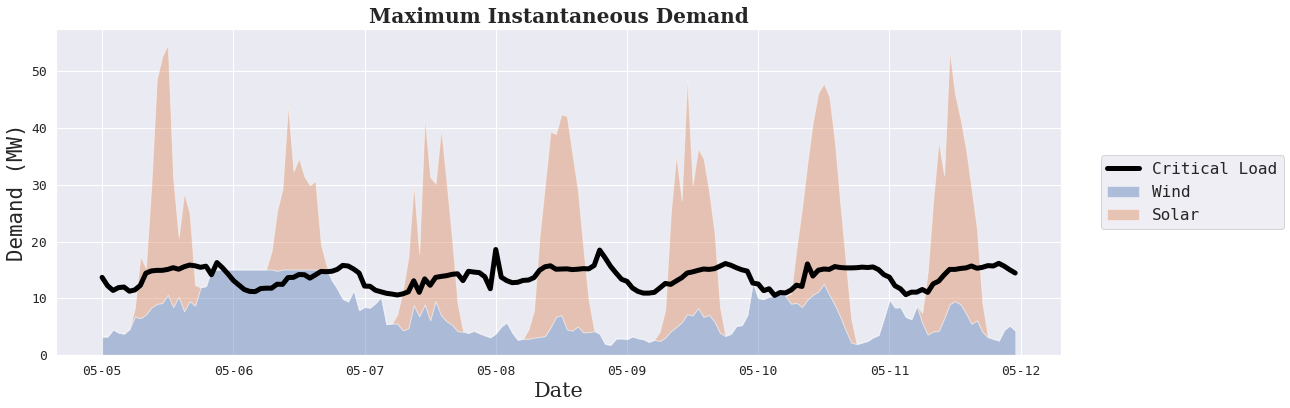

In [41]:
resilience_area_chart(resil_max_demand_df, "Maximum Instantaneous Demand")

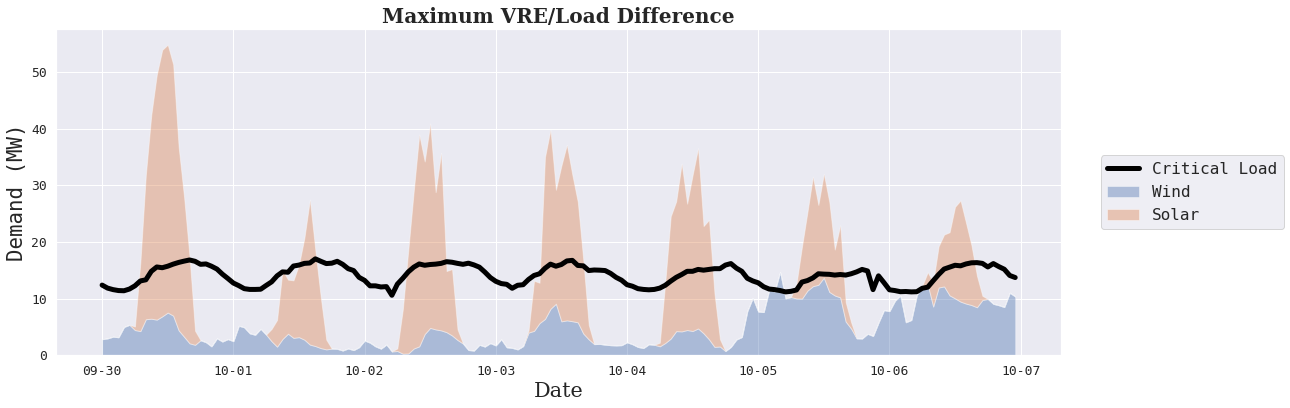

In [42]:
resilience_area_chart(resil_max_vre_load_diff_df, "Maximum VRE/Load Difference")

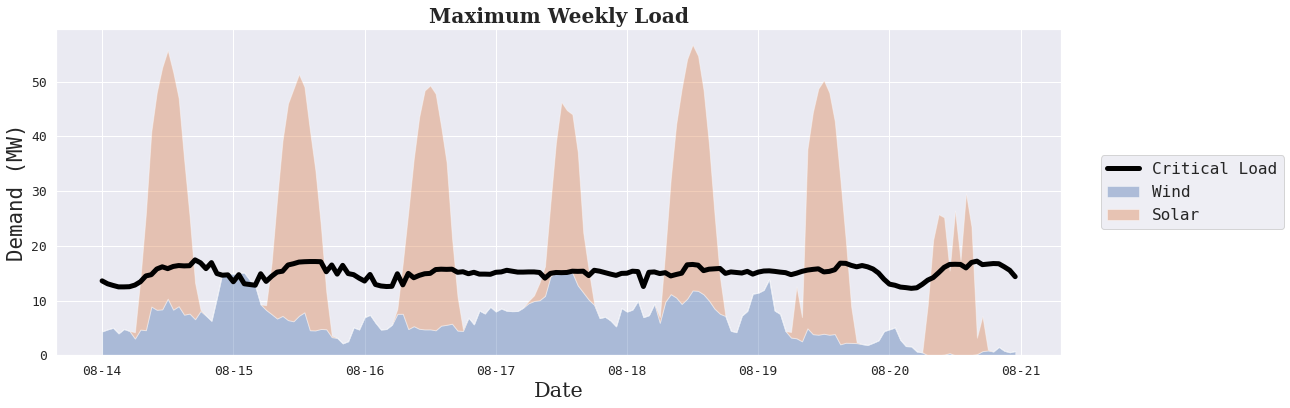

In [43]:
resilience_area_chart(resil_max_week_load_df, "Maximum Weekly Load")

In [44]:
# we added some last minute changes to the calculations, which we didn't incorporate into the python notebook.
# the full_resilience_df_manual.csv has updated values for all of the batt/h2 dispatch
manually_edited_df = pd.read_csv(os.path.join(FINAL_DATA_DIR, "full_resilience_df_manual.csv"))
manually_edited_df.head(24)

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,hour,week,load_w_transmission_loss_and_load_scale,...,h2_combination_load_mw_colname,h2_curtailed_vre,h2_thermal_gen_delta,h2_real_thermal_prod,h2_real_remaing_load,h2_vre_to_grid,h2_fuel_cell_to_grid,h2_vre_to_h2_prod,h2_final_curtailed_vre,h2_curtail_available_for_cruise
0,1/1/17 0:00,35.1,1.68,0.0000,1.0,1.0,1.0,0.0,52.0,35.1,...,0.0000,0.0,0.0,35.000000,4.1,1.6800,0.000000,0.0000,0.000000e+00,0.0
1,1/1/17 1:00,35.1,1.23,0.0000,1.0,1.0,1.0,1.0,52.0,35.1,...,0.0000,0.0,0.0,35.000000,4.1,1.2300,0.000000,0.0000,0.000000e+00,0.0
2,1/1/17 2:00,34.6,1.09,0.0000,1.0,1.0,1.0,2.0,52.0,34.6,...,0.0000,0.0,0.0,34.600000,3.6,1.0900,0.000000,0.0000,0.000000e+00,0.0
3,1/1/17 3:00,34.2,1.47,0.0000,1.0,1.0,1.0,3.0,52.0,34.2,...,0.0000,0.0,0.0,34.200000,3.2,1.4700,0.000000,0.0000,0.000000e+00,0.0
4,1/1/17 4:00,33.8,1.12,0.0000,1.0,1.0,1.0,4.0,52.0,33.8,...,0.0000,0.0,0.0,33.800000,2.8,1.1200,0.000000,0.0000,0.000000e+00,0.0
5,1/1/17 5:00,33.4,0.91,0.0000,1.0,1.0,1.0,5.0,52.0,33.4,...,0.0000,0.0,0.0,33.400000,2.4,0.9100,0.000000,0.0000,0.000000e+00,0.0
6,1/1/17 6:00,33.3,1.84,0.0000,1.0,1.0,1.0,6.0,52.0,33.3,...,0.0000,0.0,0.0,33.300000,2.3,1.8400,0.000000,0.0000,0.000000e+00,0.0
7,1/1/17 7:00,33.8,1.59,6.8978,1.0,1.0,1.0,7.0,52.0,33.8,...,5.6878,0.0,0.0,33.800000,2.8,2.8000,0.000000,5.6878,-1.530000e-13,0.0
8,1/1/17 8:00,34.7,1.18,21.3585,1.0,1.0,1.0,8.0,52.0,34.7,...,18.8385,0.0,0.0,30.429179,3.7,3.7000,0.000000,18.8385,-3.550000e-14,0.0
9,1/1/17 9:00,34.7,0.78,27.9603,1.0,1.0,1.0,9.0,52.0,34.7,...,25.0403,0.0,0.0,10.000000,3.7,3.7000,0.000000,25.0403,0.000000e+00,0.0


In [45]:
example_week = get_weekly_df(manually_edited_df, 188) # the 188th day happens 

example_week['date'] = pd.to_datetime(example_week['date'])

example_week

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,hour,week,load_w_transmission_loss_and_load_scale,...,h2_combination_load_mw_colname,h2_curtailed_vre,h2_thermal_gen_delta,h2_real_thermal_prod,h2_real_remaing_load,h2_vre_to_grid,h2_fuel_cell_to_grid,h2_vre_to_h2_prod,h2_final_curtailed_vre,h2_curtail_available_for_cruise
0,2017-07-01 00:00:00,39.6,3.05,0.0,7.0,1.0,182.0,0.0,26.0,39.6,...,0.00,0.0,0.0,35.0,8.6,3.05,1.6,0.00,0.000000e+00,0.0
1,2017-07-01 01:00:00,37.3,7.21,0.0,7.0,1.0,182.0,1.0,26.0,37.3,...,0.91,0.0,0.0,35.0,6.3,6.30,0.0,0.91,4.440000e-15,0.0
2,2017-07-01 02:00:00,37.7,7.75,0.0,7.0,1.0,182.0,2.0,26.0,37.7,...,1.05,0.0,0.0,35.0,6.7,6.70,0.0,1.05,3.200000e-14,0.0
3,2017-07-01 03:00:00,37.0,9.32,0.0,7.0,1.0,182.0,3.0,26.0,37.0,...,3.32,0.0,0.0,35.0,6.0,6.00,0.0,3.32,1.780000e-13,0.0
4,2017-07-01 04:00:00,36.8,10.38,0.0,7.0,1.0,182.0,4.0,26.0,36.8,...,4.58,0.0,0.0,35.0,5.8,5.80,0.0,4.58,4.800000e-14,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2017-07-07 19:00:00,44.3,2.10,0.0,7.0,7.0,188.0,19.0,27.0,44.3,...,0.00,0.0,0.0,35.0,13.3,2.10,7.2,0.00,0.000000e+00,0.0
164,2017-07-07 20:00:00,44.0,2.70,0.0,7.0,7.0,188.0,20.0,27.0,44.0,...,0.00,0.0,0.0,35.0,13.0,2.70,6.3,0.00,0.000000e+00,0.0
165,2017-07-07 21:00:00,42.4,2.82,0.0,7.0,7.0,188.0,21.0,27.0,42.4,...,0.00,0.0,0.0,35.0,11.4,2.82,4.6,0.00,0.000000e+00,0.0
166,2017-07-07 22:00:00,39.7,2.76,0.0,7.0,7.0,188.0,22.0,27.0,39.7,...,0.00,0.0,0.0,35.0,8.7,2.76,2.0,0.00,0.000000e+00,0.0


In [46]:
def weekly_dispatch_area_chart(df, plt_title):
    
    fig = plt.figure()
    area_ch_subplot_ax = fig.add_subplot(1, 1, 1)    
    
    plt.stackplot(df[date_colname], \
              df[wind_gen_colname], df[solar_gen_colname], \
              labels=['Wind','Solar'], alpha=0.4 )
    plt.plot(date_colname, critical_load_mw_colname, label="Critical Load", data=df, linewidth=5,color="black")
    subplot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    plt.ylabel("Demand (MW)", family='monospace' ,fontsize="xx-large")
    plt.xlabel("Date", family='serif', fontsize="xx-large")
    plt.xticks(fontsize=13, family='monospace' ) # Rotate ticks. Doesn't look great, imo: rotation = 15, ha='right'
    plt.yticks(fontsize=13, family='monospace' )
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'family': 'monospace'})
    plt.title(plt_title, family='serif', fontdict={"fontweight": "bold", "size": 20})
    plt.show()

    return

In [47]:
# df = example_week.copy()
# plt_title="Title"
# fig = plt.figure()
# area_ch_subplot_ax = fig.add_subplot(1, 1, 1)    

# pal = [
#     "#000000", # thermal
#     "#5b8269", #batt / h2
#     "#3e61ed", # wind
#     "#e69515" # solar
# ]
# plt.stackplot(df[date_colname], \
#     df[battery_final_thermal_prod_mw_colname], df[battery_discharge_mw_colname],\
#     df[wind_gen_colname], df[solar_gen_colname], 
#     labels=['Thermal Prod', 'Battery Discharge', 'Wind','Solar'], alpha=0.4, colors=pal )
# #plt.plot(date_colname, critical_load_mw_colname, label="Critical Load", data=df, linewidth=5,color="black")
# plt.plot(date_colname, load_w_transmission_loss_and_load_scale_colname, label="Load", data=example_week, linewidth=5,color="black")
# subplot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# plt.ylabel("Demand (MW)", family='monospace' ,fontsize="xx-large")
# plt.xlabel("Date", family='serif', fontsize="xx-large")
# plt.xticks(fontsize=13, family='monospace' ) # Rotate ticks. Doesn't look great, imo: rotation = 15, ha='right'
# plt.yticks(fontsize=13, family='monospace' )
# plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'family': 'monospace'})
# plt.title(plt_title, family='serif', fontdict={"fontweight": "bold", "size": 20})
# plt.show()

In [48]:
def weekly_dispatch(df, thermal_prod_colname, storage_discharge_colname, storage_discharge_friendly, plt_title):

    fig = plt.figure()
    area_ch_subplot_ax = fig.add_subplot(1, 1, 1)    

    pal = [
        "#000000", # thermal
        "#5b8269", #batt / h2
        "#3e61ed", # wind
        "#e69515" # solar
    ]
    plt.stackplot(df[date_colname], \
        df[thermal_prod_colname], df[storage_discharge_colname],\
        df[wind_gen_colname], df[solar_gen_colname], 
        labels=['Thermal Prod', storage_discharge_friendly, 'Wind','Solar'], alpha=0.4, colors=pal )
    #plt.plot(date_colname, critical_load_mw_colname, label="Critical Load", data=df, linewidth=5,color="black")
    plt.plot(date_colname, load_w_transmission_loss_and_load_scale_colname, label="Load", data=example_week, linewidth=5,color="black")
    area_ch_subplot_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    plt.ylabel("Demand (MW)", family='monospace' ,fontsize="xx-large")
    plt.xlabel("Date", family='serif', fontsize="xx-large")
    plt.xticks(fontsize=13, family='monospace' ) # Rotate ticks. Doesn't look great, imo: rotation = 15, ha='right'
    plt.yticks(fontsize=13, family='monospace' )
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'family': 'monospace'})
    plt.title(plt_title, family='serif', fontdict={"fontweight": "bold", "size": 20})
    plt.show()
    
    return 

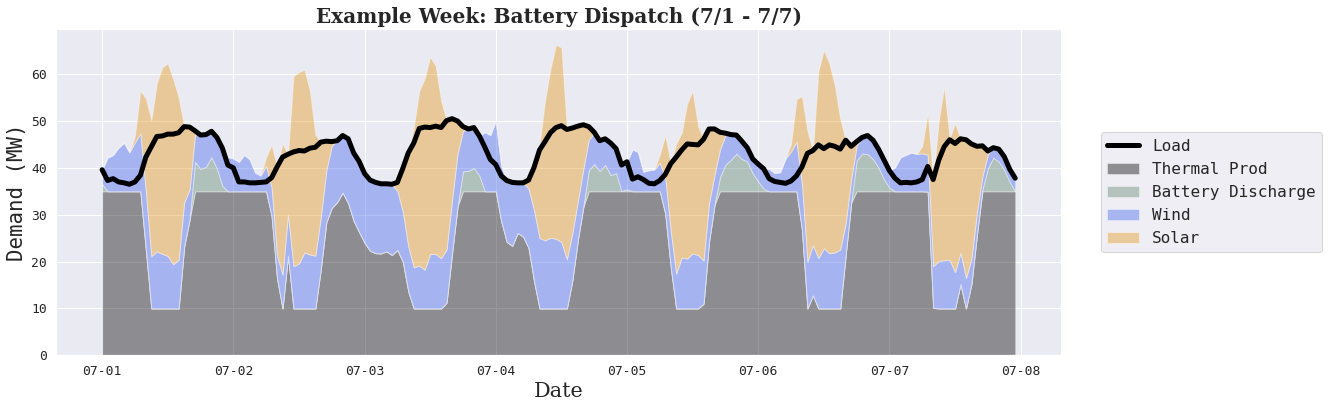

In [49]:
weekly_dispatch(
    example_week, 
    battery_final_thermal_prod_mw_colname, 
    battery_discharge_mw_colname, 
    "Battery Discharge", 
    "Example Week: Battery Dispatch (7/1 - 7/7)"
)

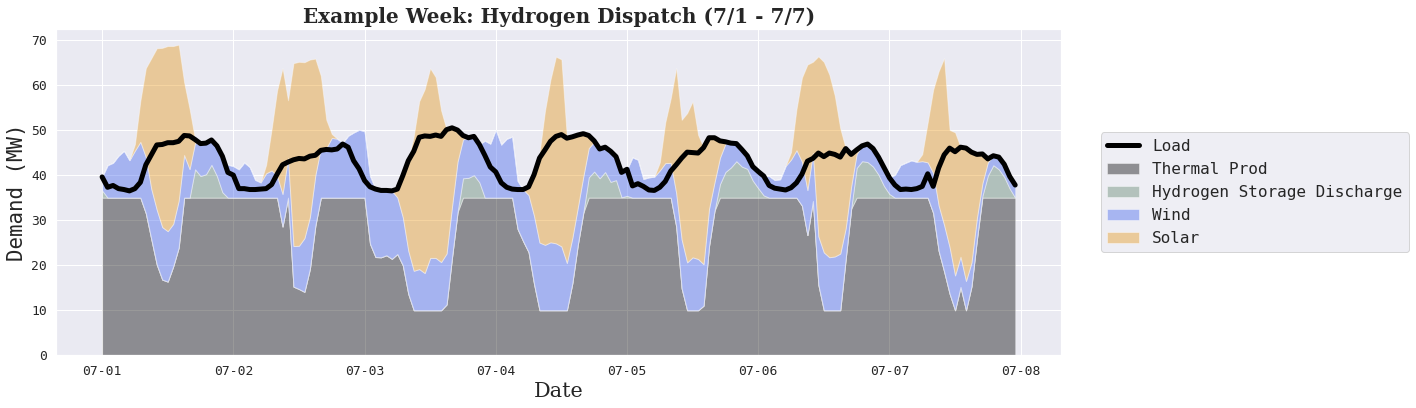

In [50]:
weekly_dispatch(
    example_week, 
    h2_real_thermal_prod_colname, 
    h2_fuel_cell_to_grid_colname, 
    "Hydrogen Storage Discharge", 
    "Example Week: Hydrogen Dispatch (7/1 - 7/7)"
)